In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath("."))

# Read train/test data

x_train = pd.read_csv(f"{ROOT_DIR}/data/x_train.csv")
y_train = pd.read_csv(f"{ROOT_DIR}/data/y_train.csv")

x_test = pd.read_csv(f"{ROOT_DIR}/data/x_test.csv")
y_test = pd.read_csv(f"{ROOT_DIR}/data/y_test.csv")

# input_data
input_data = pd.read_csv(f"{ROOT_DIR}/data/input_data.csv")

/var/folders/06/vdx5d26x60j4tt4cqzfnj7nr0000gn/T/ipykernel_14577/624625863.py:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  input_data = pd.read_csv(f"{ROOT_DIR}/data/input_data.csv")


In [3]:
columns_to_keep = ["temperature", "dewPoint", "windDirection", "windSpeed", "barometricPressure", 
                   "visibility", "seaLevelPressure", "relativeHumidity", "elevation", "textDescription"]
input_data = input_data[columns_to_keep]

# Convert categorical values to numeric
label_encoder = LabelEncoder()
input_data['textDescription'] = label_encoder.fit_transform(input_data['textDescription'])

input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380965 entries, 0 to 380964
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   temperature         380865 non-null  float64
 1   dewPoint            380862 non-null  float64
 2   windDirection       380746 non-null  float64
 3   windSpeed           380820 non-null  float64
 4   barometricPressure  380866 non-null  float64
 5   visibility          344491 non-null  float64
 6   seaLevelPressure    783 non-null     float64
 7   relativeHumidity    380861 non-null  float64
 8   elevation           380965 non-null  int64  
 9   textDescription     380965 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 29.1 MB


<AxesSubplot:>

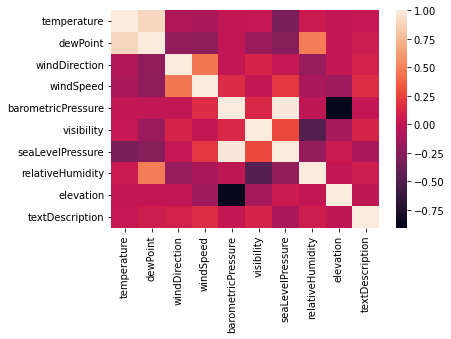

In [4]:
corr = input_data.corr()

sns.heatmap(corr)

In [5]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.5:
            if columns[j]:
                columns[j] = False
                
selected_columns = input_data.columns[columns]

input_data = input_data[selected_columns]
selected_columns

Index(['temperature', 'windDirection', 'windSpeed', 'barometricPressure',
       'visibility', 'relativeHumidity', 'elevation', 'textDescription'],
      dtype='object')

In [6]:
selected_columns = ['temperature', 'windDirection', 'windSpeed', 'barometricPressure',
       'visibility', 'relativeHumidity', 'elevation']
x_train = x_train[selected_columns]
x_test = x_test[selected_columns]

array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'windDirection'}>,
        <AxesSubplot:title={'center':'windSpeed'}>],
       [<AxesSubplot:title={'center':'barometricPressure'}>,
        <AxesSubplot:title={'center':'visibility'}>,
        <AxesSubplot:title={'center':'relativeHumidity'}>],
       [<AxesSubplot:title={'center':'elevation'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

<Figure size 432x288 with 0 Axes>

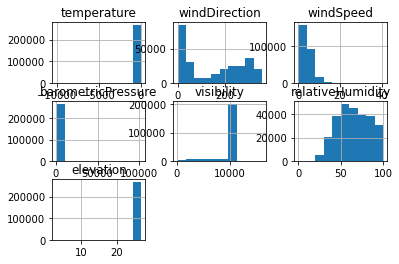

In [7]:
plt.subplots_adjust(left=0.8,
                    bottom=0.8, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.9)

x_train.hist()

In [8]:
x_train['textDescription'] = y_train['textDescription']
x_test['textDescription'] = y_test['textDescription']

# Remove null values based on selected columns

x_train = x_train[~x_train.isna().any(axis=1)]
x_test = x_test[~x_test.isna().any(axis=1)]


y_train = x_train['textDescription']
x_train.drop('textDescription', axis=1, inplace=True)

y_test = x_test['textDescription']
x_test.drop('textDescription', axis=1, inplace=True)

In [9]:
def train_model(x_train, y_train, x_test, y_test):
    # Train model
    gnb = GaussianNB().fit(x_train, y_train.values.ravel())

    # Predict 
    gnb_predictions = gnb.predict(x_test)

    # accuracy on x_test
    accuracy = gnb.score(x_test, y_test)
    print(f"Accuracy: {accuracy}")
    
    print(classification_report(y_test, gnb_predictions, target_names=y_test.unique().tolist()))
    
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, gnb_predictions, average='weighted')

    print(f"Precision: {precision}, Recall: {recall}, F-score: {fscore}")
    
    # creating a confusion matrix
    cm = confusion_matrix(y_test, gnb_predictions)
    print(cm)
    
    return gnb_predictions

In [10]:
def formulate_result_df(y_test, predictions):
    # Formulate result dataframe
    result = x_test.copy()
    result['expected'] = y_test
    result['predicted'] = predictions
    mismatched_data =  result[result['expected'] != result['predicted']]
    
    return result, mismatched_data

In [11]:
gnb_predictions = train_model(x_train, y_train, x_test, y_test)
result, mismatched_data = formulate_result_df(y_test, gnb_predictions)

Accuracy: 0.3460037003671307
                     precision    recall  f1-score   support

              Clear       0.44      0.01      0.01     34327
Light Precipitation       0.71      0.62      0.66     11499
      Partly Cloudy       0.52      0.64      0.57      5206
               Haze       0.01      0.00      0.00       510
           Fog/Mist       1.00      0.00      0.00      9848
      Mostly Cloudy       0.18      0.00      0.00     14492
      Precipitation       0.29      1.00      0.45     25101
Heavy Precipitation       0.14      0.02      0.03      2250

           accuracy                           0.35    103233
          macro avg       0.41      0.29      0.22    103233
       weighted avg       0.45      0.35      0.22    103233

Precision: 0.4459446331237882, Recall: 0.3460037003671307, F-score: 0.21773658157100348
[[  255    27    26    58     0     0 33961     0]
 [   11  7077  2292     6     0     8  2016    89]
 [  185   296  3351     0     0     1  1340   

### Convert to normal distribution

In [12]:
x_train.skew()

temperature           -0.154475
windDirection          0.204991
windSpeed              1.007685
barometricPressure    21.173802
visibility            -2.743717
relativeHumidity       0.008199
elevation            -23.374551
dtype: float64

In [13]:
x_test.skew()

temperature           -0.154576
windDirection          0.209475
windSpeed              0.947127
barometricPressure    22.104381
visibility            -2.753927
relativeHumidity       0.014580
elevation            -24.074378
dtype: float64

In [14]:
x_train['barometricPressure'],parameters=stats.boxcox(x_train['barometricPressure'])
x_test['barometricPressure'],parameters= stats.boxcox(x_test['barometricPressure'])

In [15]:
gnb_predictions = train_model(x_train, y_train, x_test, y_test)
result, mismatched_data = formulate_result_df(y_test, gnb_predictions)

Accuracy: 0.39294605407185684
                     precision    recall  f1-score   support

              Clear       0.62      0.20      0.30     34327
Light Precipitation       0.70      0.64      0.67     11499
      Partly Cloudy       0.48      0.63      0.55      5206
               Haze       0.01      0.00      0.00       510
           Fog/Mist       0.30      0.00      0.00      9848
      Mostly Cloudy       0.02      0.00      0.00     14492
      Precipitation       0.31      0.92      0.47     25101
Heavy Precipitation       0.12      0.01      0.02      2250

           accuracy                           0.39    103233
          macro avg       0.32      0.30      0.25    103233
       weighted avg       0.42      0.39      0.31    103233

Precision: 0.4168904681013523, Recall: 0.39294605407185684, F-score: 0.3145650022465792
[[ 6734    61   107    47     8     0 27367     3]
 [   61  7366  2210     9     8    54  1752    39]
 [  449   329  3282     0     5    12  1109  

### Drop elevation

In [16]:
x_train.drop('elevation', axis=1, inplace=True)
x_test.drop('elevation', axis=1, inplace=True)

In [17]:
gnb_predictions = train_model(x_train, y_train, x_test, y_test)
result, mismatched_data = formulate_result_df(y_test, gnb_predictions)

Accuracy: 0.45026299729737584
                     precision    recall  f1-score   support

              Clear       0.51      0.53      0.52     34327
Light Precipitation       0.67      0.77      0.72     11499
      Partly Cloudy       0.90      0.27      0.41      5206
               Haze       0.07      0.00      0.00       510
           Fog/Mist       0.18      0.01      0.02      9848
      Mostly Cloudy       0.02      0.00      0.00     14492
      Precipitation       0.35      0.71      0.47     25101
Heavy Precipitation       0.11      0.01      0.01      2250

           accuracy                           0.45    103233
          macro avg       0.35      0.29      0.27    103233
       weighted avg       0.40      0.45      0.39    103233

Precision: 0.398097934644133, Recall: 0.45026299729737584, F-score: 0.39123899532860784
[[18279   100     5     1    52    15 15871     4]
 [  689  8902    70     2    88   556  1167    25]
 [ 1514   913  1382     0   353   323   702  

### Drop visibility

In [18]:
x_train.drop('visibility', axis=1, inplace=True)
x_test.drop('visibility', axis=1, inplace=True)

In [19]:
gnb_predictions = train_model(x_train, y_train, x_test, y_test)
result, mismatched_data = formulate_result_df(y_test, gnb_predictions)

Accuracy: 0.45761529743396007
                     precision    recall  f1-score   support

              Clear       0.51      0.72      0.60     34327
Light Precipitation       0.46      0.92      0.61     11499
      Partly Cloudy       0.27      0.13      0.18      5206
               Haze       0.10      0.00      0.00       510
           Fog/Mist       0.18      0.04      0.07      9848
      Mostly Cloudy       0.31      0.07      0.12     14492
      Precipitation       0.41      0.39      0.40     25101
Heavy Precipitation       0.00      0.00      0.00      2250

           accuracy                           0.46    103233
          macro avg       0.28      0.28      0.25    103233
       weighted avg       0.40      0.46      0.40    103233

Precision: 0.3960871479568331, Recall: 0.45761529743396007, F-score: 0.39665176487286224
[[24855  1313   490     0   500   493  6676     0]
 [  308 10541   112     1   106   217   212     2]
 [ 1364  1266   689     0   175   232  1480 